In [1]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

In [7]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata_lambdas = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))
adata_lambdas = adata_lambdas.raw.to_adata()  # revert to count data

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


In [9]:
adata_lambdas.X.min()

0.0

In [3]:
# Read in raw counts, lambdas for all spots + genes

all_stcounts = [] # maps filename_and_coordinates to count vector
all_lambdas = [] # maps filename_and_coordinates to lambda vector

gene_index = None

for i in tqdm(range(len(meta))):
    row = meta.iloc[i]
    name = meta.index[i]
    
    count_file = os.path.join(count_dir, Path(row['Count file']).name)
    lambda_file = os.path.join(lambda_dir, Path(row['Annotation file']).name.replace(
        'annotations.txt', 'lambdas.csv'))
    
    if not (os.path.exists(count_file) and os.path.exists(lambda_file)):
        continue
        
    df_count = pd.read_csv(count_file, header=0, index_col=0, sep='\t')
    df_lambda = pd.read_csv(lambda_file, header=0, index_col=0, sep=',')
    
    if gene_index is None:
        gene_index = df_count.index.intersection(df_lambda.index)
    spots_filtered = df_lambda.columns
    
    # Ensure that genes are ordered identically b/w raw counts and lambdas
    df_count = df_count.loc[gene_index, spots_filtered]
    df_lambda = df_lambda.loc[gene_index, spots_filtered]
    
    df_count.columns = [name + '_' + cstr for cstr in spots_filtered]
    df_lambda.columns = [name + '_' + cstr for cstr in spots_filtered]
    
    all_stcounts.append(df_count)
    all_lambdas.append(df_lambda)

all_stcounts = pd.concat(all_stcounts, axis=1)
all_lambdas = pd.concat(all_lambdas, axis=1)

100%|██████████| 401/401 [05:35<00:00,  1.20it/s]


In [4]:
# Create AnnData object for counts + lambdas

assert all_stcounts.index.equals(all_lambdas.index), 'spot ordering does not match b/w counts and lambdas!'
assert all_stcounts.columns.equals(all_lambdas.columns), 'gene ordering does not match b/w counts and lambdas'

obs = pd.DataFrame(index=all_stcounts.columns)
var = pd.DataFrame(index=all_stcounts.index)

# Translate ENSEMBL gene names to common names by left-joining Sanja's mapping file
df_map = pd.read_csv(mapfile, header=None, index_col=0, sep='_')
df_map.columns = ['common']
var = var.join(df_map, how='left')

adata_st = AnnData(X=all_stcounts.values.T, obs=obs, var=var, layers={'mean_lambda':all_lambdas.values.T})

# Calculate detection rate for each gene
adata_st.var['nnz'] = (adata_st.X > 0).sum(axis=0)
adata_st.var['detection'] = adata_st.var.nnz / adata_st.obs.shape[0]

/tmp/ipykernel_631233/509717297.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_st = AnnData(X=all_stcounts.values.T, obs=obs, var=var, layers={'mean_lambda':all_lambdas.values.T})


In [5]:
# Depth-normalize, log-transform, and scale both raw counts and lambdas before calculating correlation
adata_st_pp = adata_st.copy()

print('ST counts preprocessing...')
sc.pp.normalize_total(adata_st_pp, target_sum=1e4)
#sc.pp.log1p(adata_st_pp)
#sc.pp.scale(adata_st_pp)

print('cSplotch lambdas preprocessing...')
sc.pp.normalize_total(adata_st_pp, target_sum=1e4, layer='mean_lambda')
#sc.pp.log1p(adata_st_pp, layer='mean_lambda')
#sc.pp.scale(adata_st_pp, layer='mean_lambda')

ST counts preprocessing...
cSplotch lambdas preprocessing...


Calculate correlation between counts/lambdas across all spots for each gene, then scatter as a function of detection rate

In [6]:
df_counts = pd.DataFrame(data=adata_st_pp.X)
df_lambdas = pd.DataFrame(data=adata_st_pp.layers['mean_lambda'])

corr = df_counts.corrwith(df_lambdas, axis=0, method='pearson')

In [7]:
adata_st_pp.var['lambda_corr'] = corr.values
adata_st_pp.var['lcpd'] = adata_st_pp.var['lambda_corr'] + adata_st_pp.var['detection']

adata_st_pp.var.sort_values('lcpd', axis=0, ascending=False)[:1000].to_csv('mouse_colon_splotch_highsnr.csv')
adata_st_pp.var.sort_values('lcpd', axis=0, ascending=True)[:3000].to_csv('mouse_colon_splotch_lowsnr.csv')

In [19]:
# List of genes selected by Splotch (and Sanja) to be annotated on the scatterplot
genes_ab = ['Epcam', 'Tff3', 'Ceacam1', 'Cd48', 'Acta2']
plot_common, plot_ensembl = [], []

for g in genes_ab:
    if not g in adata_st_pp.var.common.values:
        print(g, 'not found!')
    else:
        plot_common.append(g)
        plot_ensembl.append(adata_st_pp.var.index[adata_st_pp.var.common.values == g].values[0])
print(plot_ensembl)
print(plot_common)

['ENSMUSG00000045394.8', 'ENSMUSG00000024029.4', 'ENSMUSG00000074272.10', 'ENSMUSG00000015355.13', 'ENSMUSG00000035783.8']
['Epcam', 'Tff3', 'Ceacam1', 'Cd48', 'Acta2']


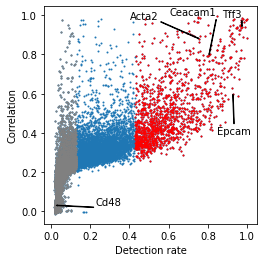

In [20]:
fig, ax = plt.subplots(1, figsize=(4,4))

# Color points according to detection rate
det = adata_st_pp.var.detection.values
low_snr, hi_snr = np.percentile(det, np.array([50, 90]))
ax.scatter(det, corr, s=1)
ax.scatter(det[det < low_snr], corr[det < low_snr], s=1, c='gray')
ax.scatter(det[det > hi_snr], corr[det > hi_snr], s=1, c='red')

ax.set_xlabel('Detection rate')
ax.set_ylabel('Correlation')
ax.set_aspect('equal')

for g, ens in zip(plot_common, plot_ensembl):
    x, y = adata_st_pp.var.loc[ens, 'detection'], adata_st_pp.var.loc[ens, 'lambda_corr']
    
    if g == 'Cd48':
        xoff, yoff = 0.2, 0
    elif g == 'Fabp4':
        xoff, yoff = 0.2, -0.3
    elif g == 'Acta2':
        xoff, yoff = -0.35, 0.1
    elif g == 'Tff3':
        xoff, yoff = -0.1, 0.05
    elif g == 'Epcam':
        xoff, yoff = -0.08, -0.2
    elif g == 'Ceacam1':
        xoff, yoff = -0.2, 0.2
    else:
        xoff, yoff = 0,0
    
    ax.annotate(g, xy=(x, y), xytext=(x+xoff,y+yoff), 
                arrowprops=dict(facecolor='black', width=0.5, headwidth=1, headlength=1))
    
plt.savefig(os.path.join(data_dir, 'counts_lambdas_corr.pdf'), format='PDF', dpi=300)
plt.show()

For a given gene, scatter components of GLM against normalized counts for each spot

In [10]:
ensembl, common = 'ENSMUSG00000024029.4', 'Tff3'

splotch_inputs = os.path.join(data_dir, 'vanilla_splotch_inputs')
splotch_outputs = os.path.join(data_dir, 'vanilla_splotch_outputs_summary')

sinfo = pickle.load(open(os.path.join(splotch_inputs, 'information.p'), 'rb'))
gid = list(sinfo['genes']).index(ensembl) + 1

data_in = read_rdump(os.path.join(splotch_inputs, str(gid//100), 'data_%d.R' % gid))
post_summary = h5py.File(os.path.join(splotch_outputs, str(gid//100), 'combined_%d.hdf5' % gid), 'r')

# Respect the same ordering of spots for counts, GLM components
spots_idx = ['_'.join(s[0].split('/')[1].split('_')[:2] + [s[1]]) for s in sinfo['filenames_and_coordinates']]
common_spots_idx = np.intersect1d(spots_idx, adata_st_pp.obs.index)

In [11]:
# Scale raw counts to the same scaling factor as cSplotch
adata_st_dnorm = adata_st.copy()
sc.pp.normalize_total(adata_st_dnorm, target_sum=sinfo['scaling_factor'])

In [12]:
counts_vec_dnorm = np.array(adata_st_dnorm[common_spots_idx, ensembl].X).squeeze()

In [13]:
# Create DataFrame representations of beta, beta+psi, and lambda
beta_vec = np.zeros(len(spots_idx))
tissue_idx = 0
for i in range(len(beta_vec)):
    if i >= np.sum(data_in['N_spots'][:tissue_idx+1]):
        tissue_idx += 1
    a_ind = data_in['D'][i]-1
    b_ind = data_in['tissue_mapping'][tissue_idx]-1
    beta_vec[i] = post_summary['beta_level_3']['mean'][b_ind, a_ind]
df_beta = pd.DataFrame(data=np.exp(beta_vec), index=spots_idx)

df_beta_psi = pd.DataFrame(data=np.exp(beta_vec + post_summary['psi']['mean'][:]), index=spots_idx)

df_lambda = pd.DataFrame(data=post_summary['lambda']['mean'][:], index=spots_idx)

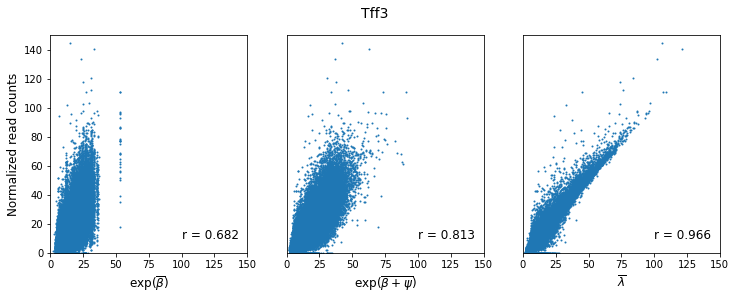

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

for i in range(3):
    ax[i].set_xlim(0, 150)
    ax[i].set_ylim(0, 150)

r, _ = pearsonr(df_beta.loc[common_spots_idx][0], counts_vec_dnorm)
ax[0].scatter(df_beta.loc[common_spots_idx][0], counts_vec_dnorm, s=1)
ax[0].text(100, 10, 'r = %.3f' % r, fontsize=12)
ax[0].set_xlabel(r'$\exp(\overline{\beta}$)', fontsize=12)
ax[0].set_ylabel('Normalized read counts', fontsize=12)

r, _ = pearsonr(df_beta_psi.loc[common_spots_idx][0], counts_vec_dnorm)
ax[1].scatter(df_beta_psi.loc[common_spots_idx], counts_vec_dnorm, s=1)
ax[1].text(100, 10, 'r = %.3f' % r, fontsize=12)
ax[1].set_xlabel(r'$\exp(\overline{\beta + \psi})$', fontsize=12)
ax[1].set_yticks([])

r, _ = pearsonr(df_lambda.loc[common_spots_idx][0], counts_vec_dnorm)
ax[2].scatter(df_lambda.loc[common_spots_idx], counts_vec_dnorm, s=1)
ax[2].text(100, 10, 'r = %.3f' % r, fontsize=12)
ax[2].set_xlabel(r'$\overline{\lambda}$', fontsize=12)
ax[2].set_yticks([])

plt.suptitle(common, fontsize=14)
plt.savefig(os.path.join(data_dir, 'glm_counts_corr_tff3.pdf'), format='PDF', dpi=300)
plt.show()